In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.constants import pi, e, k, mu_0

In [2]:
# Constant terms
C_loss = 6 * pi**2 * 10e19 * 10e-3 * e  *1e-2# for W in MW.s
C_fus = 17.59 * e * 1.18e-24 * 10**(2*19) * pi**2 / 2  # for P_fus in MW
C_beta = 4e2 * mu_0 * 1e19 * 1e3 * e  # beta expressed in %
C_n = 10/pi  # for n in 10^19 m^-3
C_I = 2 * pi * 1e-6 / mu_0  # for I in MA
C_SL = 0.0562  # confinement time in s

In [3]:
print(f'C_loss={C_loss}')  # factor 1e-2 ?
print(f'C_fus={C_fus}')  # OK
print(f'C_beta={C_beta}')  # OK
print(f'C_n={C_n}')  # OK
print(f'C_I={C_I}')  # OK
print(f'C_SL={C_SL}') # OK

C_loss=0.09487709656782095
C_fus=0.001641073326484171
C_beta=0.8053418082653762
C_n=3.183098861837907
C_I=4.999999999999999
C_SL=0.0562


In [4]:
def nTtau_fromQ(Q=10, lambd=5):
    " n.T.tau_e from eq (2.33) "
    return C_loss/C_fus * Q / (1+Q/lambd)

def nTtau(M=1, kappa=1, epsilon=1, qa=1, n_N=1, R=1, B=1, beta_N=2.8):
    # (n*T*Tau)^0.31
    _nTTau = C_SL * C_n**0.41 * C_I **0.96 * C_beta**0.38 * M**0.19 * kappa**0.09 * \
             epsilon**0.68 * qa**(-0.96) * n_N**0.41 * R**0.42 * B**0.73 * beta_N**(-0.38)
    return _nTTau**(1/0.31)

In [5]:
# check from §2.8
nTtau_fromQ(Q=10)

192.71350247155067

In [15]:
def beta_N_(P_DT=410, kappa=3.4, epsilon=0.32, qa=2, R=6.2, B=5.3):
    " beta_N from expression (2.23) "
    beta_N = np.sqrt(P_DT * C_beta**2 * qa**2 / 
                     (C_fus * C_I**2 * kappa * epsilon**4 * R**3 * B**4) )
    return beta_N
    
def RB1(Q=10, lambd=5, M=1, kappa=3.4, epsilon=0.32, qa=2, n_N=1, beta_N=2):
    " return R**0.42 * B**0.73 "
    # (n*T*Tau)^0.31
    _temp = C_SL * C_n**0.4 * C_I **0.96 * C_beta**0.38 * \
            M**0.19 * kappa**0.09 * epsilon**0.68 * qa**(-0.96) * n_N**0.41 * beta_N**(-0.38)
        
    return (C_loss/C_fus * Q/(1+Q/lambd)) / (_temp)

def RB2(P_DT=500, kappa=3.4, epsilon=0.32, qa=2, beta_N=2):
    " return R**3 * B**4 "
    return P_DT / (C_beta**(-2) * C_fus * C_I**2 * qa**(-2) * kappa * epsilon**(4) * beta_N**(2))


In [16]:
# Check consistency with ITER parameters :
# a = 2 m, b = 6.8 m -> kappa = 3.4, epsilon = 0.32
# R = 6.2 m, B = 5.3, Ip = 15 MA
# Q = 10, Pfus = 500 MW
ITER = {'R': 6.2, 'B':5.3, 'a':2, 'Q':10, 'Pfus':410, 'Ip':15,
        'epsilon': 0.32, 'kappa':3.4, 'qa':3, 'beta_N':2, 'n_N':1}

beta_N_ITER = beta_N_(P_DT=ITER['Pfus'], kappa=ITER['kappa'], 
                     epsilon=ITER['epsilon'], 
                     B=ITER['B'], R=ITER['R'])

b1_ITER = RB1(Q=ITER['Q'], 
              kappa=ITER['kappa'], epsilon=ITER['epsilon'],
             qa=ITER['qa'], n_N=ITER['n_N'], beta_N=ITER['beta_N'])
b2_ITER = RB2(P_DT=ITER['Pfus'], 
              kappa=ITER['kappa'], epsilon=ITER['epsilon'], 
              qa=ITER['qa'], beta_N=ITER['beta_N'])

print(f'beta_N={beta_N_ITER}, b1={b1_ITER}, b2={b2_ITER}')

# one needs to solve for (R,B) the following system:
# R**0.42 * B**0.73 = b1
# return R**3 * B**4 = b2
# multiplying by log leads to :
# 0.42 log(R) + 0.73 log(B) = log(b1)
# 3 log(R) + 4 log(B) = log(b2)

a = np.array([[0.42, 0.73], [3, 4]])
b = np.array([np.log(b1_ITER), np.log(b2_ITER)])

x = np.linalg.solve(a,b)
R = np.exp(x[0])
B = np.exp(x[1])
print(f'x={x} -> R={R}, B={B}')

beta_N=1.9664797711898485, b1=3629.4832435388657, b2=409053.4314525514
x=[-45.79335973  37.57542006] -> R=1.2947817273806538e-20, B=2.0835195924212164e+16


In [8]:
R_ITER = 6.2
B_ITER = 5.3

b1_ITER = R_ITER**0.42 * B_ITER**0.73
b2_ITER = R_ITER**3 * B_ITER**4
print(f'ITER: b1={b1_ITER}, b2={b2_ITER}')

ITER: b1=7.269857437594987, b2=188052.2555768


In [9]:
# let's do the opposite : what should be the best set of parameters
# in order to obtain ITER values of (R,B)
def obj_fun(x):
    # fixed parameters
    lambd = 5
    Q = 10
    P_fus = 410
    # target (ITER)
    b1_ITER = 7.269857437594987
    b2_ITER = 188052.2555768
    
    epsilon = 0.32
    kappa = 3.4
    # parameters to find
    qa, n_N, beta_N = x
    
    b1 = RB1(Q=Q, lambd=lambd, kappa=kappa, epsilon=epsilon,
            qa=qa, n_N=n_N, beta_N=beta_N)
    b2 = RB2(P_DT=P_fus, kappa=kappa, epsilon=epsilon,
             qa=qa, beta_N=beta_N)

    # return scalar objective function
    return np.sqrt((b1 - b1_ITER)**2 + (b2 - b2_ITER)**2)


In [10]:
qa, beta_N, n_N = 3, 1.9, 1

x0 = [qa, n_N, beta_N]

x = minimize(obj_fun, x0)
x

C:\Users\JH218595\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
C:\Users\JH218595\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
C:\Users\JH218595\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
C:\Users\JH218595\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
C:\Users\JH218595\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return

      fun: nan
 hess_inv: array([[ 2.80076264e-02, -1.68906056e+00,  2.75492236e-02],
       [-1.68906056e+00,  1.01959159e+02, -1.66141564e+00],
       [ 2.75492236e-02, -1.66141564e+00,  2.70983238e-02]])
      jac: array([nan, nan, nan])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1211
      nit: 19
     njev: 242
   status: 2
  success: False
        x: array([-1242.87124629, 75223.38615835, -1222.51715156])

In [14]:
beta_N()

TypeError: 'float' object is not callable

Text(0.5,0,'R [m]')

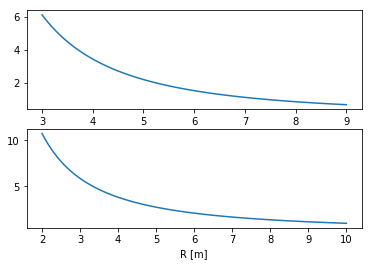

In [17]:
_B = np.linspace(3, 9, 101)
_R = np.linspace(2, 10, 101)

fig, axes = plt.subplots(2, 1)
axes[0].plot(_B, beta_N_(B=_B))
axes[0].set_xlabel('B at $R_0$ [T]')
axes[1].plot(_R, beta_N_(R=_R))
axes[1].set_xlabel('R [m]')